In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [24]:
class ChestXRayClassifier:
    def __init__(self, data_directory, csv_file, target_size=(64, 64), batch_size=16):
        self.data_directory = data_directory
        self.csv_file = csv_file
        self.target_size = target_size
        self.batch_size = batch_size
        self.datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Conv2D(128, (3, 3), activation='relu', input_shape=self.target_size + (3,)),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(3, activation='softmax')
        ])
        return model

    def compile_model(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def train_model(self):
        train_generator = self.datagen.flow_from_directory(
            self.data_directory,
            batch_size=self.batch_size,
            subset='training',
            target_size=self.target_size
        )
        validation_generator = self.datagen.flow_from_directory(
            self.data_directory,
            batch_size=self.batch_size,
            subset='validation',
            target_size=self.target_size
        )
        history = self.model.fit(
            train_generator,
            epochs=90,
            validation_data=validation_generator
        )
        return history

    def plot_history(self, history):
        # summarize history for accuracy
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    def perform_eda(self):
        df_train = pd.read_csv(self.csv_file)
        print(df_train.head())

        # Plot the distribution of classes
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df_train, x='Label')  
        plt.title('Distribution of Classes')
        plt.show()

        # Sample a few images to display
        self.display_sample_images(df_train)

    def display_sample_images(self, df, n=5):
        sample_df = df.groupby('Label').sample(n=n, random_state=1)
        for label in df['Label'].unique():
            fig, axes = plt.subplots(1, n, figsize=(20, 5))
            fig.suptitle(f'Sample images for class: {label}')
            sample_images = sample_df[sample_df['Label'] == label]
            for ax, (_, row) in zip(axes, sample_images.iterrows()):
                image_subfolder = label.lower() 
                image_path = os.path.join(self.data_directory, image_subfolder, row['Image'])
                if not os.path.isfile(image_path):
                    print(f"File not found: {image_path}")
                    continue
                image = plt.imread(image_path)
                ax.imshow(image)
                ax.axis('off')
            plt.show()


In [25]:
data_directory = 'train' 
csv_file = 'train.csv'  

In [26]:
classifier = ChestXRayClassifier(data_directory, csv_file)

            Image   Label
0  597631776.jpeg  normal
1   35266064.jpeg   virus
2  467414642.jpeg  normal
3   35667640.jpeg  normal
4  618841263.jpeg  normal


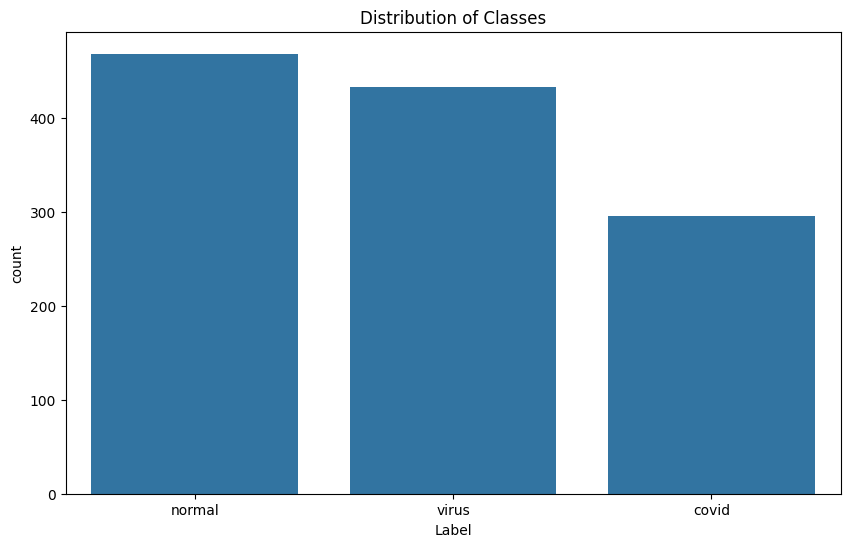

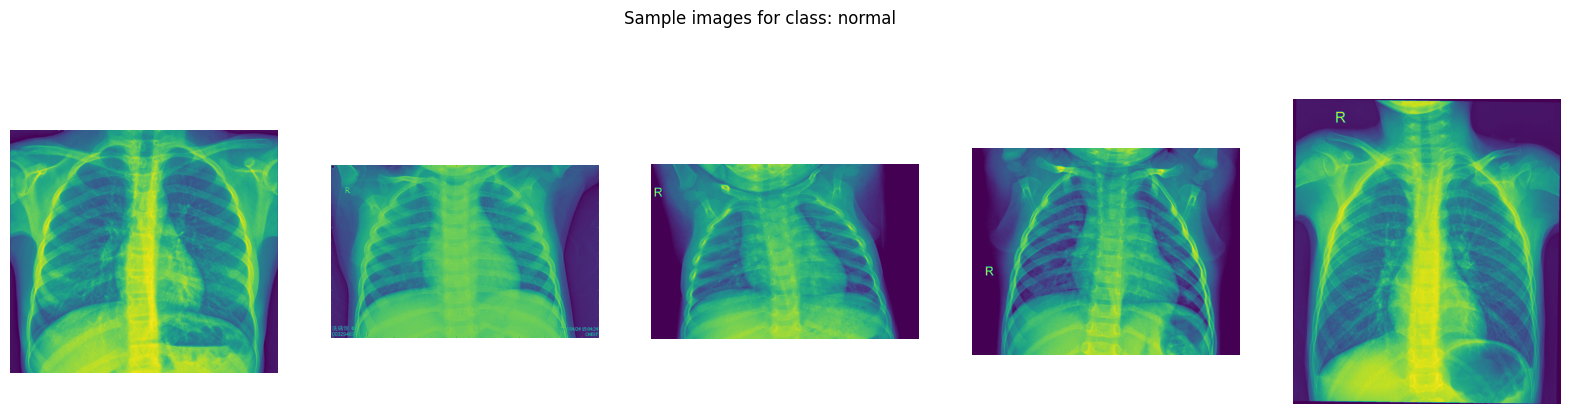

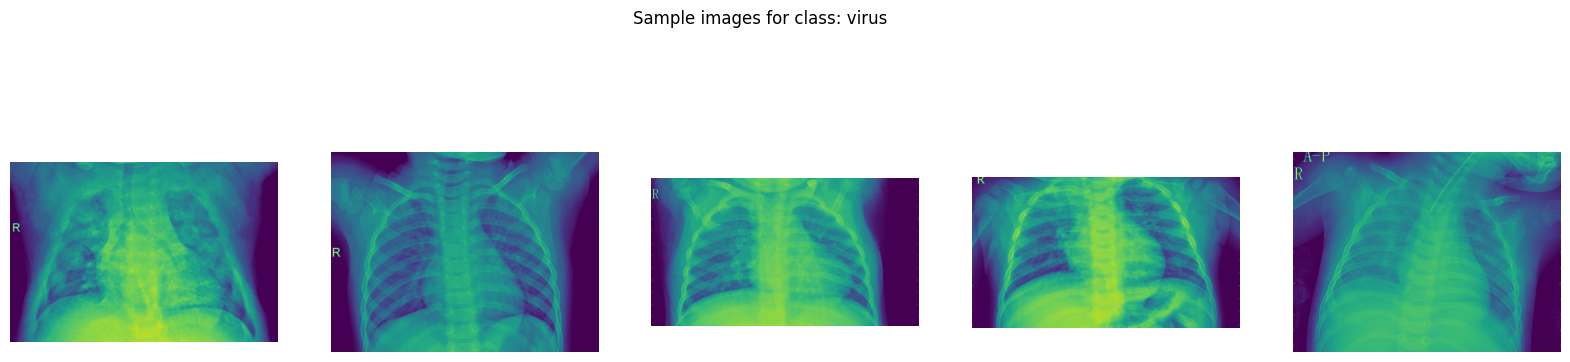

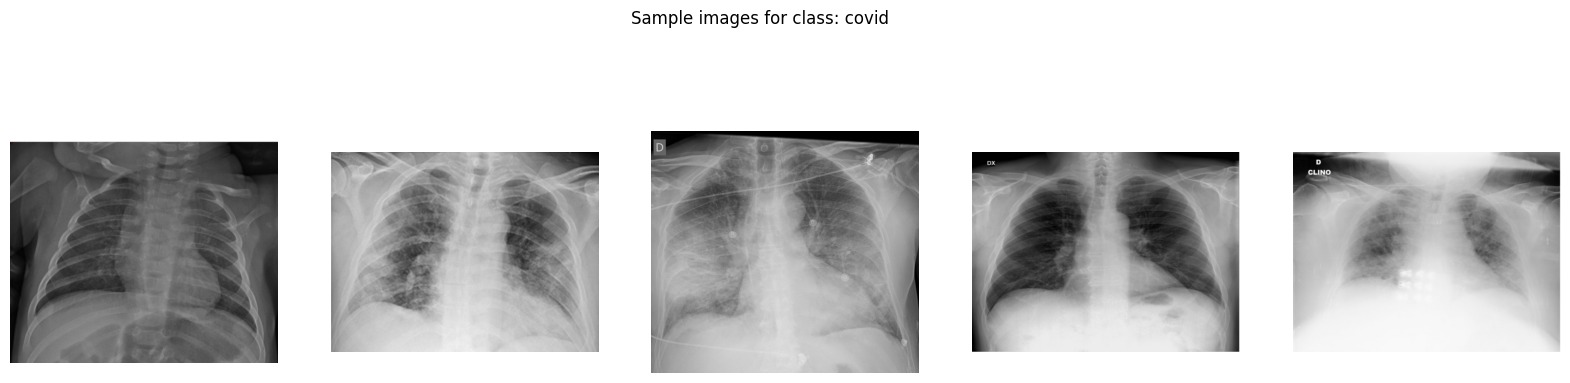

In [27]:
classifier.perform_eda() 

- Sample Images for Classes:

These are representative X-ray images from the dataset, sorted by class: normal, virus, and covid.
Such visualizations are crucial for understanding the dataset's content and ensuring that the images are correctly labeled and of sufficient quality for the model to learn.

- Distribution of Classes Bar Chart:

This bar chart shows the count of images for each class in the dataset.
The 'normal' class has the highest count, followed by 'virus', and the 'covid' class has the lowest count. This could indicate a class imbalance, which might affect model training and would typically need to be addressed, either through resampling techniques or adjusted class weighting during model training.

In [28]:
classifier.compile_model()

In [29]:
history = classifier.train_model()

Found 958 images belonging to 3 classes.
Found 238 images belonging to 3 classes.
Epoch 1/90
60/60 [==============================] - 26s 401ms/step - loss: 0.9650 - accuracy: 0.4666 - val_loss: 1.1728 - val_accuracy: 0.5882
Epoch 2/90
60/60 [==============================] - 24s 401ms/step - loss: 0.6207 - accuracy: 0.7328 - val_loss: 0.4286 - val_accuracy: 0.8193
Epoch 3/90
60/60 [==============================] - 23s 381ms/step - loss: 0.4080 - accuracy: 0.8372 - val_loss: 0.3415 - val_accuracy: 0.8824
Epoch 4/90
60/60 [==============================] - 23s 388ms/step - loss: 0.2833 - accuracy: 0.8852 - val_loss: 0.3361 - val_accuracy: 0.8571
Epoch 5/90
60/60 [==============================] - 21s 354ms/step - loss: 0.2785 - accuracy: 0.8987 - val_loss: 0.2670 - val_accuracy: 0.9202
Epoch 6/90
60/60 [==============================] - 21s 349ms/step - loss: 0.1752 - accuracy: 0.9311 - val_loss: 0.2340 - val_accuracy: 0.9076
Epoch 7/90
60/60 [==============================] - 22s 368m

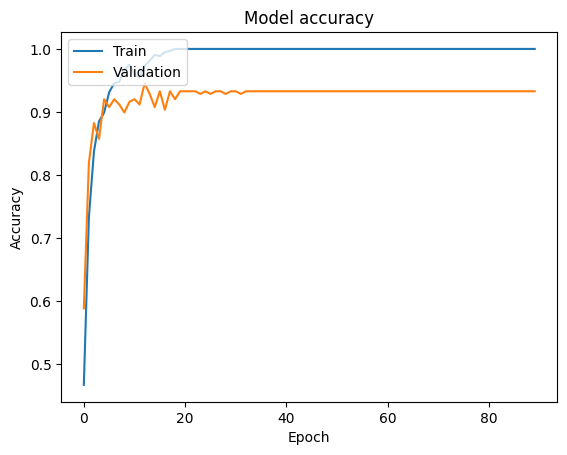

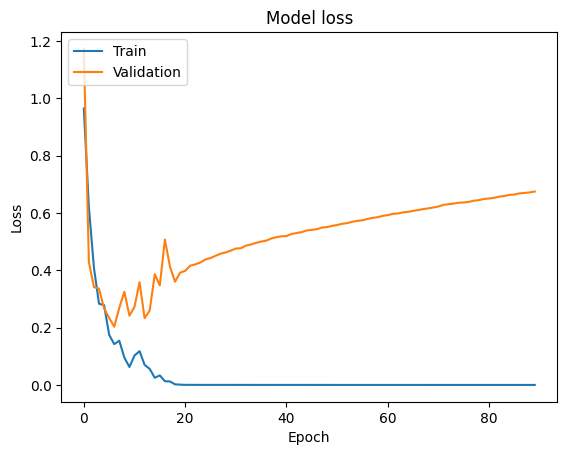

In [30]:
classifier.plot_history(history)

- Model Loss Plot:

The plot shows the loss of the model over training epochs for both the training and validation datasets.
Initially, there's a sharp decrease in training loss, indicating rapid learning. However, the validation loss decreases and then starts to increase, which could be a sign of overfitting, as the model learns patterns specific to the training data that do not generalize well to the validation data.

- Model Accuracy Plot:

This plot represents the accuracy of the model over training epochs for both training and validation datasets.
The training accuracy improves steadily and approaches 1 (or 100%), while the validation accuracy also increases but plateaus, suggesting the model might not be improving further with more training.